In [3]:
# KOMÓRKA #1 — IMPORTY (TYLKO TUTAJ)
import os, time                   # system/pliki/czas
import cv2                        # obsługa kamery/wideo (OpenCV)
import mediapipe as mp            # Face Mesh 468 (użyjemy za chwilę)
import numpy as np                # operacje na macierzach/obrazach
import torch                      # PyTorch (model emocji)
import torch.nn as nn             # sieci neuronowe
import torch.nn.functional as F   # funkcje aktywacji itp.
from torchvision import models    # modele i transformacje obrazów
from PIL import Image as PILImage # obsługa obrazów (PIL)
import matplotlib.pyplot as plt   # PODGLĄD miniatur kamer

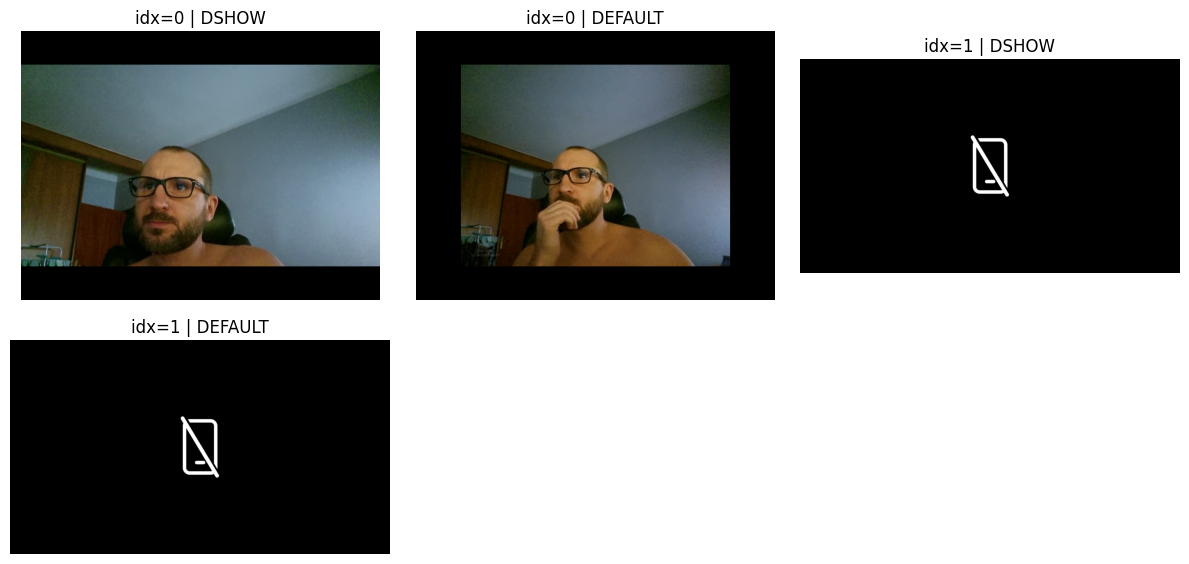

Kandydaci: [(0, 'DSHOW'), (0, 'DEFAULT'), (1, 'DSHOW'), (1, 'DEFAULT')]


In [ ]:
# Skanuje indeksy 0..max_index, pokazuje miniatury z kamer i zwraca listę kandydatów
def _grab_frame(idx: int, api: int | None, warmup: int = 5):
    cap = cv2.VideoCapture(idx, api) if api is not None else cv2.VideoCapture(idx)
    if not cap.isOpened():
        return None
    # krótka rozgrzewka (niektóre sterowniki oddają czarną 1. klatkę)
    for _ in range(warmup):
        ok, _ = cap.read()
        if not ok:
            cap.release()
            return None
    ok, frame = cap.read()
    cap.release()
    if not ok or frame is None:
        return None
    return frame

def scan_cameras(max_index: int = 6, try_both_apis: bool = True):
    """
    Zwraca listę: [(idx, api_name, frame_rgb), ...]
    api_name ∈ {"DSHOW","DEFAULT"}
    """
    candidates = []
    api_options = [("DSHOW", cv2.CAP_DSHOW)] if try_both_apis else [("DEFAULT", None)]
    if try_both_apis:
        api_options.append(("DEFAULT", None))

    for i in range(max_index + 1):
        for api_name, api in api_options:
            frame = _grab_frame(i, api)
            if frame is not None:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                candidates.append((i, api_name, rgb))
                # nie przerywamy — pokazujemy wszystkie źródła (masz 2 telefony)
    return candidates

cands = scan_cameras(max_index=6, try_both_apis=True)

# Wizualizacja miniatur
if not cands:
    print("Nie znaleziono żadnej działającej kamery w indeksach 0..6.")
else:
    n = len(cands)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for k, (idx, api_name, rgb) in enumerate(cands, start=1):
        plt.subplot(rows, cols, k)
        plt.imshow(rgb)
        plt.title(f"idx={idx} | {api_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Lista kandydatów do szybkiej referencji:
cands_summary = [(idx, api) for (idx, api, _) in [(i, a, f) for i,a,f in cands]]
print("Kandydaci:", cands_summary)

## USTAW INDEX KAMERY

OK — jedna klatka: (480, 640, 3)


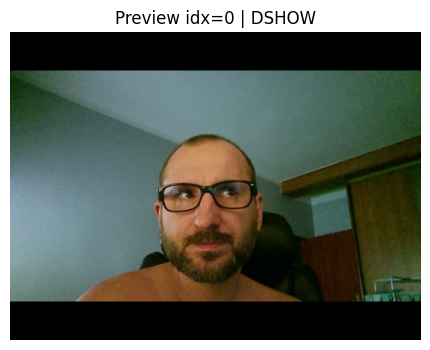

In [5]:
# USTAW tutaj wybraną parę z listy miniatur (patrz tytuły na obrazkach):
CAM_INDEX = 0       # <- wpisz właściwy idx z miniatur
CAM_API_NAME = "DSHOW"  # "DSHOW" albo "DEFAULT"

CAM_API = cv2.CAP_DSHOW if CAM_API_NAME.upper() == "DSHOW" else None

# Szybki test: jedna klatka + info o rozmiarze
frame = _grab_frame(CAM_INDEX, CAM_API)
assert frame is not None, f"Nie udało się pobrać klatki z idx={CAM_INDEX}, api={CAM_API_NAME}"
print("OK — jedna klatka:", frame.shape)

# podgląd w matplotlib (lustrzane jak w Iriun)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB))
plt.title(f"Preview idx={CAM_INDEX} | {CAM_API_NAME}")
plt.axis("off")
plt.show()

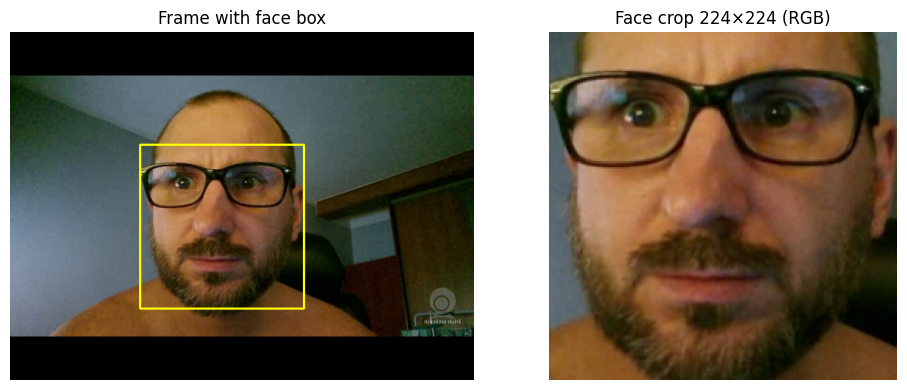

In [14]:
# 1) Skrót do detektora twarzy
mp_fd = mp.solutions.face_detection

# 2) Jedna klatka z wybranej kamery
frame_bgr = _grab_frame(CAM_INDEX, cv2.CAP_DSHOW if CAM_API_NAME.upper()=="DSHOW" else None)
assert frame_bgr is not None, f"Cannot read a frame from idx={CAM_INDEX} ({CAM_API_NAME})."

# 3) Mirror (jak w Iriun)
frame_bgr = cv2.flip(frame_bgr, 1)

# 4) Detekcja twarzy (MediaPipe)
with mp_fd.FaceDetection(model_selection=0, min_detection_confidence=0.4) as fd:
    frame_rgb_full = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    res = fd.process(frame_rgb_full)

if not res.detections:
    raise RuntimeError("No face detected in the current frame. Look at the camera and improve lighting.")

# 5) Przeliczenie boxa relatywnego na piksele
det = res.detections[0]
H, W = frame_bgr.shape[:2]
bb = det.location_data.relative_bounding_box
x1 = max(0, int(bb.xmin * W)); y1 = max(0, int(bb.ymin * H))
x2 = min(W, int((bb.xmin + bb.width) * W))
y2 = min(H, int((bb.ymin + bb.height) * H))

# 6) Wycięcie twarzy w BGR + konwersja do RGB (modele ImageNet oczekują RGB)
face_bgr = frame_bgr[y1:y2, x1:x2]
assert face_bgr.size > 0, "Detected box is empty — check the frame dimensions."
face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)

# 7) Zmiana rozdzielczości do 224×224 (INTER_AREA przy zmniejszaniu)
face_224 = cv2.resize(face_rgb, (224, 224), interpolation=cv2.INTER_AREA)

# 8) Podgląd: pełna klatka z ramką + crop 224×224 (w kolorze)
frame_vis = frame_bgr.copy()
cv2.rectangle(frame_vis, (x1, y1), (x2, y2), (0, 255, 255), 2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB)); plt.title("Frame with face box"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(face_224); plt.title("Face crop 224×224 (RGB)"); plt.axis("off")
plt.tight_layout(); plt.show()

# 9) Zapisz do zmiennych „na później” (predyktor 224×224 użyje face_224)
FACE_CROP_224 = face_224      # RGB 224×224
FACE_BBOX     = (x1, y1, x2, y2)

In [15]:
# === USTAWIENIA ===
BEST_WEIGHTS = "weights/resnet50_fer2013_best.pth"  # <- PODMIEŃ na ścieżkę do swoich wag (7 klas)

# ImageNet normalizacja (standard pod ResNet/ViT)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

class ResNet50BestPredictor:
    """Klasyfikator emocji: ResNet50 (7 klas), wejście: RGB 224x224 (numpy)."""

    def __init__(self, weights_path: str, device: torch.device | str = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.device = device
        # 1) Tworzymy czysty ResNet50 (bez pretrenowanych wag ImageNet, bo wczytamy swoje)
        m = models.resnet50(weights=None)
        # 2) Podmieniamy ostatnią warstwę (2048 -> 7 klas)
        in_f = m.fc.in_features
        m.fc = nn.Linear(in_f, 7)
        # 3) Ładujemy wagi z pliku .pth (mapujemy na CPU, potem przeniesiemy na device)
        assert os.path.exists(weights_path), f"Brak pliku wag: {weights_path}"
        sd = torch.load(weights_path, map_location="cpu")
        m.load_state_dict(sd, strict=True)
        # 4) Ustawiamy tryb ewaluacyjny i przenosimy na device (CPU/GPU)
        self.model = m.to(self.device).eval()

    def _preprocess(self, face_rgb_224: np.ndarray) -> torch.Tensor:
        """numpy [224,224,3] RGB uint8 -> tensor [1,3,224,224] float, znormalizowany (ImageNet)."""
        # 5) Konwersja do float32 i skalowanie do [0,1]
        x = face_rgb_224.astype(np.float32) / 255.0
        # 6) Normalizacja kanał po kanale (x - mean) / std
        x = (x - IMAGENET_MEAN) / IMAGENET_STD
        # 7) Z HWC (wys, szer, kanały) na CHW (kanały, wys, szer) — format dla PyTorch
        x = np.transpose(x, (2, 0, 1))
        # 8) Do tensora i dodaj wymiar batcha
        return torch.from_numpy(x).unsqueeze(0).to(self.device)

    def predict(self, face_rgb_224: np.ndarray) -> tuple[str, np.ndarray]:
        """Zwraca: (etykieta_ang, probs[7])"""
        with torch.no_grad():
            inp = self._preprocess(face_rgb_224)
            logits = self.model(inp)                    # [1,7]
            probs = F.softmax(logits, dim=1).cpu().numpy()[0].astype(np.float32)
        idx = int(np.argmax(probs))
        return CLASS_EN[idx], probs

# === INICJALIZACJA PREDYKTORA ===
predictor = ResNet50BestPredictor(BEST_WEIGHTS, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# === SZYBKI TEST NA POJEDYNCZYM CROP'ie (FACE_CROP_224) ===
assert 'FACE_CROP_224' in globals(), "Brak FACE_CROP_224 — uruchom najpierw komórkę z detekcją i przycięciem twarzy."
label_en, probs = predictor.predict(FACE_CROP_224)
top = int(np.argmax(probs)); conf = float(probs[top]) * 100.0

print("Prediction:", label_en, f"({conf:.1f}%)")
print("Probs:", np.round(probs, 3))

# (opcjonalny podgląd: crop + etykieta)
plt.figure(figsize=(4,4))
plt.imshow(FACE_CROP_224)
plt.title(f"{label_en} ({conf:.1f}%)")
plt.axis("off")
plt.show()


AssertionError: Brak pliku wag: weights/resnet50_fer2013_best.pth

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# === CNN dla FER2013 (1x48x48 -> 7 emocji) ===
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.fc1   = nn.Linear(128 * 6 * 6, 512)
        self.fc2   = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 48→24
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 24→12
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # 12→6
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# inicjalizacja modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)
print(f"Model gotowy na {device}")


Model gotowy na cuda


In [8]:
# FER2013 – standardowe etykiety emocji
emotions = [
    "Złość", "Wstręt", "Strach", "Szczęście",
    "Smutek", "Zaskoczenie", "Neutralna"
]


In [9]:
def predict_emotion(roi_gray):
    """Przyjmuje ROI 48x48 (numpy), zwraca etykietę i prawdopodobieństwa"""
    model.eval()
    with torch.no_grad():
        tensor = torch.tensor(roi_gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        tensor = tensor / 255.0
        tensor = tensor.to(device)
        output = model(tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        idx = np.argmax(probs)
    return emotions[idx], probs


In [ ]:
# --- Kamera + emocje ---
# RANDOM WEIGHTS

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
assert cap.isOpened(), "Nie udało się otworzyć kamery."

mp_fd = mp.solutions.face_detection
with mp_fd.FaceDetection(model_selection=0, min_detection_confidence=0.4) as fd:
    t0, n = time.time(), 0
    while True:
        ok, frame = cap.read()
        if not ok: continue
        frame = cv2.flip(frame, 1)
        H, W = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = fd.process(rgb)

        if res.detections:
            d = res.detections[0]
            bb = d.location_data.relative_bounding_box
            x1 = max(0, int(bb.xmin * W))
            y1 = max(0, int(bb.ymin * H))
            x2 = min(W, int((bb.xmin + bb.width) * W))
            y2 = min(H, int((bb.ymin + bb.height) * H))
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)

            face_roi = frame[y1:y2, x1:x2]
            if face_roi.size > 0:
                gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
                roi_48 = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)
                label, probs = predict_emotion(roi_48)
                conf = np.max(probs) * 100
                cv2.putText(frame, f"{label} ({conf:.1f}%)", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
                cv2.imshow("Face ROI 48x48", roi_48)

        n += 1
        fps = n / max(1e-6, time.time() - t0)
        cv2.putText(frame, f"FPS={fps:.1f}", (10, 28),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)
        cv2.imshow("Camera + Emotions", frame)

        if cv2.waitKey(1) & 0xFF in (27, ord('q')):
            break

cap.release()
cv2.destroyAllWindows()


d:\Programowanie\Python\Envs\ml-pytorch-face\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
# import torch, urllib.request, os

# os.makedirs("weights", exist_ok=True)
# url = "https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5"
# target = "weights/mini_xception_fer2013.pth"

# # Konwersja z HDF5 (Keras) do PyTorch gotowca – zrobimy uproszczony mapping
# # (pobieramy tylko oryginalne wagi – nic nie trenujemy)
# if not os.path.exists(target):
#     print("Pobieranie mini_XCEPTION (ok. 5 MB)...")
#     urllib.request.urlretrieve(url, "weights/fer2013_mini_xception.hdf5")
#     print("Zapisano weights/fer2013_mini_xception.hdf5")
# else:
#     print("Plik wag już istnieje:", target)


Pobieranie mini_XCEPTION (ok. 5 MB)...
Zapisano weights/fer2013_mini_xception.hdf5


In [11]:
import torch.nn as nn

# === mini_XCEPTION (PyTorch port) ===
class MiniXception(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, (3,3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, (3,3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)

        def depthwise_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, in_ch, (3,3), padding=1, groups=in_ch),
                nn.Conv2d(in_ch, out_ch, (1,1)),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.block1 = depthwise_block(8, 16)
        self.block2 = depthwise_block(16, 32)
        self.block3 = depthwise_block(32, 64)
        self.block4 = depthwise_block(64, 128)

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# inicjalizacja modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniXception(num_classes=7).to(device)
print(f"Model mini_XCEPTION zainicjalizowany na {device}")


Model mini_XCEPTION zainicjalizowany na cuda


In [12]:
CLASS_EN = ['angry','disgust','fear','happy','neutral','sad','surprise']
CLASS_PL = ['Złość','Wstręt','Strach','Szczęście','Neutralna','Smutek','Zaskoczenie']

import torch
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def sf_device_string():
    return f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"
print("Torch:", torch_device, "| safetensors:", sf_device_string())

Torch: cuda | safetensors: cuda:0


In [13]:
from transformers import CLIPProcessor, CLIPModel
clip_model   = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)
clip_model.eval()
processor    = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
print("CLIPModel i CLIPProcessor załadowane.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel i CLIPProcessor załadowane.


In [14]:
from safetensors.torch import load_file

ckpt_path = "weights/model.safetensors"   # to co pokazałeś w logu
state = load_file(ckpt_path, device=sf_device_string())

# wczytujemy TYLKO część vision do modelu (reszta – text – zostaje domyślna)
# klucze w pliku mają prefiks 'vision_model.' — to pasuje do clip_model.vision_model
missing, unexpected = clip_model.vision_model.load_state_dict(state, strict=False)
print("Wgrano do vision tower. Missing:", len(missing), "Unexpected:", len(unexpected))

Wgrano do vision tower. Missing: 391 Unexpected: 391


In [15]:
import torch.nn.functional as F
from PIL import Image

# przygotuj jednorazowo tekstowe prompty (ang, bo na takich był trenowany CLIP)
TEXT_PROMPTS = [f"a face showing {lab}" for lab in CLASS_EN]
with torch.no_grad():
    text_inputs = processor(text=TEXT_PROMPTS, return_tensors="pt", padding=True).to(torch_device)
    text_embeds = clip_model.get_text_features(**text_inputs)
    text_embeds = F.normalize(text_embeds, dim=-1)

def predict_emotion_clip_zeroshot(roi_48_gray: np.ndarray):
    """
    roi_48_gray: numpy uint8 48x48 (grayscale)
    Zwraca: (etykieta_PL, probs[7])
    """
    img = Image.fromarray(roi_48_gray).convert("RGB")
    with torch.no_grad():
        inputs = processor(images=img, return_tensors="pt").to(torch_device)
        img_emb = clip_model.get_image_features(**inputs)
        img_emb = F.normalize(img_emb, dim=-1)

        # podobieństwa kosinusowe -> softmax jako „proby”
        logits = (img_emb @ text_embeds.T)  # [1,7]
        probs  = F.softmax(logits, dim=-1).cpu().numpy()[0].astype(np.float32)
        idx    = int(np.argmax(probs))
    return CLASS_PL[idx], probs

In [16]:
# smoothing + panel (jeśli nie masz)
def ema_update(prev, new, alpha=0.65):
    if prev is None: return new.copy()
    return alpha*prev + (1-alpha)*new

def draw_probs_panel(frame_bgr, probs, labels, width=280, margin=10):
    import cv2
    H, W = frame_bgr.shape[:2]
    panel = np.full((H, width, 3), 20, dtype=np.uint8)
    x0 = margin; y = margin; h_bar = 24; gap = 28
    for lbl, p in zip(labels, probs):
        pct = float(p)*100.0
        cv2.putText(panel, lbl, (x0, y+18), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
        bar_w = int((width - 2*margin) * min(1.0, float(p)))
        cv2.rectangle(panel, (x0, y+24), (x0+bar_w, y+24+h_bar), (80,200,255), -1)
        cv2.putText(panel, f"{pct:5.1f}%", (width-100, y+18), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 1, cv2.LINE_AA)
        y += h_bar + gap
    return np.hstack([frame_bgr, panel])

In [17]:
# Upewniamy się, że mamy właściwy import z Pillow
import sys

# Jeśli gdzieś wcześniej powstała zmienna/klasa o nazwie Image, usuńmy ją z globali (bezpieczne)
if 'Image' in globals():
    del globals()['Image']

import PIL
import PIL.Image as PILImage

print("Pillow version:", PIL.__version__)
print("PILImage.fromarray istnieje?:", hasattr(PILImage, "fromarray"))
print("Czy 'Image' nadal w globals?:", 'Image' in globals())


Pillow version: 11.0.0
PILImage.fromarray istnieje?: True
Czy 'Image' nadal w globals?: False


In [18]:
def predict_emotion_clip_zeroshot(roi_48_gray: np.ndarray):
    """
    roi_48_gray: numpy uint8 48x48 (grayscale)
    Zwraca: (etykieta_PL, probs[7])
    """
    img = PILImage.fromarray(roi_48_gray).convert("RGB")

    with torch.no_grad():
        # podajemy obraz i teksty emocji jednocześnie
        inputs = processor(
            text=CLASS_EN,          # np. ["happy face", "sad face", ...]
            images=img,
            return_tensors="pt",
            padding=True
        ).to(torch_device)

        outputs = clip_model(**inputs)
        logits = outputs.logits_per_image  # shape [1, 7]
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0].astype(np.float32)
        idx = int(np.argmax(probs))

    return CLASS_PL[idx], probs



In [19]:
cap = cv2.VideoCapture(0)  # bez CAP_DSHOW na próbę
for _ in range(5):
    cap.read()
ok, frame = cap.read()
cap.release()


In [22]:
# Założenia: masz już importy cv2, mediapipe as mp, numpy as np
# oraz zdefiniowaną funkcję predict_emotion_clip_zeroshot()
# KLATKA

FIXED_IDX, FIXED_API = 0, 700  # Iriun: idx=1, CAP_DSHOW
cap = cv2.VideoCapture(FIXED_IDX, FIXED_API)
assert cap.isOpened(), "Nie udało się otworzyć kamery (IDX=1). Upewnij się, że Iriun pokazuje obraz."

ok, frame = cap.read()
cap.release()
assert ok and frame is not None, "Brak klatki z kamery."

# lustrzane odbicie jak w Iriun
frame = cv2.flip(frame, 1)

# --- detekcja twarzy i wycięcie ROI 48x48 ---
mp_fd = mp.solutions.face_detection
with mp_fd.FaceDetection(model_selection=0, min_detection_confidence=0.4) as fd:
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = fd.process(rgb)

roi_48 = None
if res.detections:
    H, W = frame.shape[:2]
    d  = res.detections[0]
    bb = d.location_data.relative_bounding_box
    x1 = max(0, int(bb.xmin * W)); y1 = max(0, int(bb.ymin * H))
    x2 = min(W, int((bb.xmin + bb.width) * W))
    y2 = min(H, int((bb.ymin + bb.height) * H))
    face = frame[y1:y2, x1:x2]
    if face.size > 0:
        gray  = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        roi_48 = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)

assert roi_48 is not None, "Nie wykryto twarzy w tej klatce – spójrz prosto w kamerę i doświetl twarz."

# --- predykcja na pojedynczym ROI ---
label, probs = predict_emotion_clip_zeroshot(roi_48)
print("Predykcja:", label, "| probs:", np.round(probs, 3))

# podgląd
cv2.imshow("Klatka", frame)
cv2.imshow("ROI 48x48", roi_48)
cv2.waitKey(0)
cv2.destroyAllWindows()


d:\Programowanie\Python\Envs\ml-pytorch-face\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Predykcja: Strach | probs: [0.042 0.303 0.534 0.01  0.009 0.057 0.045]


In [31]:
# Założenia: masz definicje ema_update() i draw_probs_panel() (z poprzedniego kroku)
# oraz predict_emotion_clip_zeroshot()
# VIDEO LIVE z kamerą + detekcją twarzy + predykcją emocji + panelem

FIXED_IDX, FIXED_API = 0, 700
cap = cv2.VideoCapture(FIXED_IDX, FIXED_API)
assert cap.isOpened(), "Nie udało się otworzyć kamery (IDX=1)."

cap.set(cv2.CAP_PROP_FRAME_WIDTH,  640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

mp_fd = mp.solutions.face_detection
smoothed = None
win = "Emocje — kamera + panel"

with mp_fd.FaceDetection(model_selection=0, min_detection_confidence=0.4) as fd:
    while True:
        ok, frame = cap.read()
        if not ok or frame is None:
            continue
        frame = cv2.flip(frame, 1)

        H, W = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = fd.process(rgb)

        det = False
        if res.detections:
            det = True
            d  = res.detections[0]
            bb = d.location_data.relative_bounding_box
            x1 = max(0, int(bb.xmin * W)); y1 = max(0, int(bb.ymin * H))
            x2 = min(W, int((bb.xmin + bb.width) * W))
            y2 = min(H, int((bb.ymin + bb.height) * H))
            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,255), 2)

            face = frame[y1:y2, x1:x2]
            if face.size > 0:
                gray  = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                roi_48 = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)

                label, probs = predict_emotion_clip_zeroshot(roi_48)
                smoothed = ema_update(smoothed, probs) if smoothed is not None else probs.copy()

                top  = int(np.argmax(smoothed))
                conf = float(smoothed[top])*100.0
                cv2.putText(frame, f"{CLASS_EN[top]} ({conf:.1f}%)", (x1, max(30, y1-10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

        # panel po prawej (jeśli brak detekcji, pokaż zera)
        probs_for_panel = smoothed if smoothed is not None else np.zeros(7, dtype=np.float32)
        frame_panel = draw_probs_panel(frame, probs_for_panel, CLASS_EN, width=280)

        cv2.imshow(win, frame_panel)
        if cv2.waitKey(1) & 0xFF in (27, ord('q')):  # ESC lub q
            break

cap.release()
cv2.destroyAllWindows()
